# A Rod-Pendulum System

**Project deadline:** This project is due for submission on Thursday, 26.06.2025, 23:55. Please check carefully the *About the Projects* section below for further details.

## About the Projects
- You will get one project approximately every other week.
- Besides the homework-assignments, you need to solve the projects in order to pass the course. Your final course mark consists of the mean of your project marks. We hand-out four projects during the term and we do not consider the worst project mark for your final course mark. Projects that you do not hand in are counted with a mark of 4.
- The project needs to be submitted by uploading this notebook on eCampus. You do not need to modify the notebooks name before your upload. Your project must be on eCampus by Thursday 26th of June, 23:55. **No late uploads can be accepted!**
- **In contrast to the homework exercises, each student must hand in an own solution for the projects! Of course you can and should discuss problems with each other! However, you need to be able to explain your solution in detail to your tutor and/or the lecturers! We might ask you for an interview about your project if the solution is (close to) identical to another students submission.**

**Note:** The tutors, Matthias and I are very happy to help you out with difficulties you might have with the project tasks! You can ask questions any time but please do so well in advance of the deadlines!

## This project

We consider the following system of a rod and two pendulums:

<center><img src="figs/rod-pendulum.png" width=400 /><center/>

The massless rod of length $2L$ can rotate freely around the origin and is assumed to be massless. The system has two mounts (point masses $m_1$ and $m_2$) at the ends of the rod to which two pendulums are connected. The pendulums (lengths $l_1$ and $l_2$) can rotate freely around the mounts. The pendulums consist of two point masses $m_3$ and $m_4$ but are massless otherwise. The only external force on the system is gravitation and the systems movement all take place in the two-dimensional $x-y$ plane.

To simplify things, we set all the four masses equal, i.e. $m = m_1 = m_2 = m_3 = m_4$ and also $l = l_1 = l_2$ with $l < L$.

## Your tasks

1. Identify generalised coordinates of the system. Write down your choice in a markdown cell.
2. Use SymPy to analytically construct the Lagragian and the equations of motion for the system.
3. Use SciPy to numerically solve the equations of motions for different initial conditions (at least 4). Use conditions that show a linear, predictable evolution of the system but also chaotic behaviour. Consider a timeline of around 50 seconds.
4. We want to test whether our numeric solution is reasonable. To this end, consider and discuss the time evolution of the total energy of the system. What is your expectation and does the numeric solution behave as it should? Please investigate longer simulation times for this task.
5. Plot and discuss the time evolution of the energies from rod (masses $m_1$, $m_2$) and the pendulums (masses $m_3$, $m_4$). 
6. Create animations showing the movements of the system.

**Remarks:** (1) In the lecture I concentrated on demonstrating SymPy and how to use it. However, from the point-of-view of *code compactness* and *code reusabilty* the notebook is not good. I basically just continuously repeated and duplicated code for the two masses and for the two generalised coordinates. This becomes cumbersome and error-prone if more masses/coordinates are involved and quickly unmaintainable if you decide to modify the system, add new masses etc. Hence, please structure your project code and data in a better way from the very beginning; (2) In the SciPy lecture, I mentioned that, besides `odeint`, there is a second numeric solver `solve_ivp` within `scipy.integrate`. One possibility to earn bonus points is to compare and to discuss solutions of both solvers.

# Task 1 


To model the dynamics of the system, we first need to define a set of **generalized coordinates**. These are the fundamental variables that completely describe the configuration of all masses at any point in time. Our system has three independent ways it can move, so it has **three degrees of freedom**.

We choose the following three angles as our generalized coordinates:

* $\phi(t)$: The angle of the main rotating rod. We define this as the angle of the vector from the origin to the mass $m_1$, measured counter-clockwise from the positive x-axis. This angle dictates the position of both $m_1$ and $m_2$.

* $\theta_1(t)$: The angle of the first pendulum (attached to $m_1$). This angle is measured from the vertical line hanging down from its pivot point, $m_1$.

* $\theta_2(t)$: The angle of the second pendulum (attached to $m_2$). This angle is also measured from the vertical line hanging down from its pivot point, $m_2$.

With these three time-dependent variables, $\phi(t)$, $\theta_1(t)$, and $\theta_2(t)$, we can determine the exact $(x,y)$ position of every mass in the system.

# Task 2 

We will now use the SymPy library to construct the Lagrangian and derive the equations of motion for the system. This involves defining the system's coordinates and constants symbolically, calculating the kinetic and potential energies, and then applying the Euler-Lagrange equations.

## 2.1: Imports and Symbolic Definitions

First, we import the necessary libraries and define all symbolic variables. We use `dynamicsymbols` for our time-dependent coordinates and specify that our physical constants are real and positive to aid SymPy's simplification engine.

In [1]:
# --- Imports and Symbolic Setup ---
import sympy as sp
import sympy.physics.mechanics as me

# Define time as a symbol
t = sp.Symbol('t')

# Define physical constants, assuming they are real and positive
m, g, L, l = sp.symbols('m g L l', real=True, positive=True)


## 2.2: System Kinematics

Next, we define the Cartesian coordinates $(x,y)$ for each of the four masses based on our generalized coordinates $(\phi, \theta_1, \theta_2)$.

In [2]:
# --- Generalized Setup for N Pendulums ---
num_pendulums = 2  # Set the number of pendulums here

# Generalized coordinates: one for the rod (phi) and N for the pendulums (thetas)
phi = me.dynamicsymbols('phi')
thetas = me.dynamicsymbols(f'theta_:{num_pendulums}')

# --- Define Cartesian Coordinates in a Loop ---
x_coords = []
y_coords = []

# Positions of the two masses on the main rod
x_coords.append(L * sp.cos(phi))
y_coords.append(L * sp.sin(phi))
x_coords.append(-L * sp.cos(phi))
y_coords.append(-L * sp.sin(phi))

# Positions of the pendulum masses
for i in range(num_pendulums):
    # The pendulum is attached to one of the rod's masses
    parent_mass_index = i 
    x_coords.append(x_coords[parent_mass_index] + l * sp.sin(thetas[i]))
    y_coords.append(y_coords[parent_mass_index] - l * sp.cos(thetas[i]))

## 2.3: System Energies and the Lagrangian

We now derive the expressions for the total kinetic energy ($T$) and total potential energy ($V$). The Lagrangian is then formed as $L = T - V$. We use `sp.Rational(1,2)` instead of `0.5` to maintain symbolic precision.

In [3]:
# Purpose: Calculates the kinetic (T) and potential (V) energies using the 
#          generalized coordinates and constructs the Lagrangian (L = T - V).

# --- Calculate Energies and Lagrangian in a Loop ---
T = 0  # Total Kinetic Energy
V = 0  # Total Potential Energy

# Sum energies for all masses
for i in range(len(x_coords)):
    x_d = sp.diff(x_coords[i], t)
    y_d = sp.diff(y_coords[i], t)
    T += sp.Rational(1, 2) * m * (x_d**2 + y_d**2)
    V += m * g * y_coords[i]

# Simplify expressions
T = sp.simplify(T)
V = sp.simplify(V)

# Construct the Lagrangian
Lagrangian = T - V

## 2.4: The Euler-Lagrange Equations

Finally, we apply the Euler-Lagrange equation, $$ \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q_i}} \right) - \frac{\partial L}{\partial q_i} = 0 $$, for each generalized coordinate $q_i \in \{ \phi, \theta_1, \theta_2 \}$. The compact `for` loop is an efficient way to do this.

In [4]:
# --- Derive the Equations of Motion ---
# ---------------------------------------------
# Purpose: Derives the Euler-Lagrange equations of motion for all 
#          generalized coordinates in a single loop.

# List of generalized coordinates and their time derivatives
q = [phi] + list(thetas)
q_d = [sp.diff(coord, t) for coord in q]

# Derive the Equations of Motion (EOM) using the Euler-Lagrange equation
EOM = []
for i in range(len(q)):
    eom_i = sp.diff(Lagrangian.diff(q_d[i]), t) - Lagrangian.diff(q[i])
    EOM.append(sp.simplify(eom_i))

Now we can display the final equations of motion. Each of these expressions is equal to zero.

In [5]:
# Display the equation of motion for phi
print("Equation of Motion for phi:")
display(EOM[0])

# Display the equation of motion for theta1
print("\nEquation of Motion for theta_1:")
display(EOM[1])

# Display the equation of motion for theta2
print("\nEquation of Motion for theta_2:")
display(EOM[2])

Equation of Motion for phi:


L*m*(4*L*Derivative(phi(t), (t, 2)) - l*sin(phi(t) - theta_0(t))*Derivative(theta_0(t), (t, 2)) + l*sin(phi(t) - theta_1(t))*Derivative(theta_1(t), (t, 2)) + l*cos(phi(t) - theta_0(t))*Derivative(theta_0(t), t)**2 - l*cos(phi(t) - theta_1(t))*Derivative(theta_1(t), t)**2)


Equation of Motion for theta_1:


l*m*(-L*sin(phi(t) - theta_0(t))*Derivative(phi(t), (t, 2)) - L*cos(phi(t) - theta_0(t))*Derivative(phi(t), t)**2 + g*sin(theta_0(t)) + l*Derivative(theta_0(t), (t, 2)))


Equation of Motion for theta_2:


l*m*(L*sin(phi(t) - theta_1(t))*Derivative(phi(t), (t, 2)) + L*cos(phi(t) - theta_1(t))*Derivative(phi(t), t)**2 + g*sin(theta_1(t)) + l*Derivative(theta_1(t), (t, 2)))

# Task 3 

Now that we have the symbolic equations, we'll solve them numerically using SciPy. This involves solving for the angular accelerations, converting them to fast numerical functions, and then using an ODE (Ordinary Differential Equation) solver to simulate the system's behavior over time.

## 3.1: Isolate Accelerations and Create Numerical Functions

First, we algebraically solve our three Equations of Motion (EOMs) for the three angular accelerations ($\ddot{\phi}$, $\ddot{\theta_1}$, $\ddot{\theta_2}$). Then, we convert these very complex symbolic expressions into a single, highly efficient numerical function using `sympy.lambdify`. This function will take the system's state and parameters as input and return the accelerations.

In [6]:
# --- Isolate Accelerations and Lambdify ---
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Purpose: Solves the EOM for the second derivatives (accelerations) and
#          creates a fast, callable numerical function for the solver.

# Get the list of all generalized coordinates and their first derivatives
q  = [phi] + list(thetas)
q_d = [sp.diff(coord, t) for coord in q]

# Now, get the second derivatives of all generalized coordinates
q_dd = [sp.diff(coord, t, 2) for coord in q]

# Solve the system of equations for all accelerations (the q_dd variables)
# This will return a dictionary mapping each acceleration symbol to its solution
EOM_sol = sp.solve(EOM, q_dd)

# Create a flat list of the variables that our numerical function will need.
# We use the splat operator (*) to unpack the lists q and q_d.
# The order must match the order in which the model function will receive them.
func_args = [*q, *q_d, m, g, L, l]

# Lambdify the expressions for all accelerations into a single callable function.
# We create a list of the solution expressions in the correct order.
accel_expressions = [EOM_sol[dd] for dd in q_dd]
accel_func = sp.lambdify(func_args, accel_expressions, 'numpy')

## 3.2: Define the ODE System for the Solver

### Solve_ivp:

We now write a function, `model`, that takes the current time $t$ and state vector $z$ and returns the derivative of the state vector, $\frac{dz}{dt}$. SciPy's `solve_ivp` will call this function repeatedly to integrate the system's motion.

The state vector is defined as: $z = [\phi, \theta_1, \theta_2, \dot{\phi}, \dot{\theta_1}, \dot{\theta_2}]$.

In [7]:
# --- Define the ODE System Function ---
def model(t, z, m_val, g_val, L_val, l_val):
    """
    Calculates the derivative of the state vector z.
    This function is compatible with scipy.integrate.solve_ivp.
    """
    # Unpack the state vector z into its components
    phi_val, theta1_val, theta2_val, phi_d_val, theta1_d_val, theta2_d_val = z
    
    # Calculate the three angular accelerations using our fast numerical function
    accelerations = accel_func(
        phi_val, theta1_val, theta2_val, 
        phi_d_val, theta1_d_val, theta2_d_val, 
        m_val, g_val, L_val, l_val
    )
    
    # The derivative of the state vector is [velocities, accelerations]
    return [phi_d_val, theta1_d_val, theta2_d_val, *accelerations]

### Odeint:

We now write a function, `model_odeint`, that takes the current state vector `z` and time `t` and returns the derivative of the state vector,  
$\frac{dz}{dt}$. SciPy's `odeint` will call this function repeatedly to integrate the system's motion.

It's important to note the argument order difference compared to `solve_ivp`: `odeint` expects the state vector `z` (often named `y`) as the **first argument**, followed by time `t`. This is because `odeint` is an older interface (wrapping a FORTRAN library) with a different API convention compared to the newer, more flexible `solve_ivp`.

The state vector is defined as:  
$z = [\phi, \theta_1, \theta_2, \dot{\phi}, \dot{\theta}_1, \dot{\theta}_2]$.


In [8]:
# --- ODE System Function for odeint ---

def model_odeint(z, t, m_val, g_val, L_val, l_val):
    """
    Calculates the derivative of the state vector z for scipy.integrate.odeint.
    Note the different order of arguments: z is first, then t.
    """
    # Unpack the state vector z into its components
    phi_val, theta1_val, theta2_val, phi_d_val, theta1_d_val, theta2_d_val = z
    
    # Calculate accelerations using the fast numerical function created earlier
    accelerations = accel_func(
        phi_val, theta1_val, theta2_val, 
        phi_d_val, theta1_d_val, theta2_d_val, 
        m_val, g_val, L_val, l_val
    )
    
    # The derivative of the state vector is [velocities, accelerations]
    return [phi_d_val, theta1_d_val, theta2_d_val, *accelerations]

## 3.3: Run Simulations

We define our constants and a set of four initial conditions to explore both predictable and chaotic behavior. Then we loop through them, solving the ODE for each case and storing the result. We specify strict solver tolerances (`rtol`, `atol`) to ensure high accuracy, which is crucial for chaotic systems.

In [9]:
# --- Define Constants and Initial Conditions ---
# We use a dictionary for the parameters for clarity
params = {
    'm': 1.0,      # mass in kg
    'g': 9.81,     # gravity in m/s^2
    'L': 1.0,      # half-length of the rod in m
    'l': 0.5       # length of the pendulums in m
}
m_val, g_val, L_val, l_val = params.values()

# Define the time span and evaluation points for the simulation
t_span = [0, 50]
t_eval = np.linspace(t_span[0], t_span[1], 2500)

# z0 = [phi, theta1, theta2, phi_d, theta1_d, theta2_d]
initial_conditions = {
    "Predictable: Small rod displ.": [0.1, 0, 0, 0, 0, 0],
    "Predictable: Symmetric pend.": [0, np.pi/10, np.pi/10, 0, 0, 0],
    "Chaotic: Asymmetric pend.": [np.pi/2, np.pi/2, -np.pi/4, 0, 0, 0],
    "Chaotic: Large rod kick": [0, 0, 0, 4.0, 0.5, -0.5]
}

# --- Solve the ODE for Each Case ---
solutions = {}
print("Solving ODEs with Solve_ivp for different initial conditions...")
for name, ic in initial_conditions.items():
    sol_obj = solve_ivp(
        fun=model,
        t_span=t_span,
        y0=ic,
        t_eval=t_eval,
        args=(m_val, g_val, L_val, l_val),
        rtol=1e-8, atol=1e-8 # Strict tolerances for better accuracy
    )
    solutions[name] = sol_obj
print("Simulations with Solve_ivp complete.")

Solving ODEs with Solve_ivp for different initial conditions...
Simulations with Solve_ivp complete.


In [10]:
# Solve the ODE System using odeint
# -----------------------------------------
# Purpose: Solves the differential equations for each set of initial
#          conditions using the `odeint` function.

solutions_odeint = {}
print("Solving ODEs with Odeint for different initial conditions....")
for name, ic in initial_conditions.items():
    # Use odeint to solve the system
    sol_odeint = odeint(
        func=model_odeint,          # The odeint-compatible model function
        y0=ic,                      # Initial conditions
        t=t_eval,                   # Time points for evaluation
        args=(m_val, g_val, L_val, l_val), # Additional arguments
        rtol=1e-8,                  # Relative tolerance
        atol=1e-8                   # Absolute tolerance
    )
    solutions_odeint[name] = sol_odeint
print("Simulations with odeint complete.")

Solving ODEs with Odeint for different initial conditions....
Simulations with odeint complete.


The numerical integration processes, employing both `solve_ivp` and `odeint` for various initial conditions, have been successfully executed. The results — comprising the time evolution of the generalized coordinates and their velocities for all four scenarios — are now available.

- The `solve_ivp` results are stored in the `solutions` dictionary.
- The `odeint` results are stored in a separate dictionary (e.g., `odeint_solutions`).

These distinct collections of data are now ready for further **analysis** and **visualization**.


## 3.4: Visualize the Time Evolution of Coordinates


To understand and compare the system's behavior across different scenarios, we will now plot the time evolution of each generalized coordinate. This visualization will include solutions obtained from both `solve_ivp` and `odeint`, allowing for a direct comparison of their outputs.

Creating a grid of plots — where each row represents a different initial condition — provides an effective way to visually contrast the **predictable** and **chaotic** motions observed with both solvers.


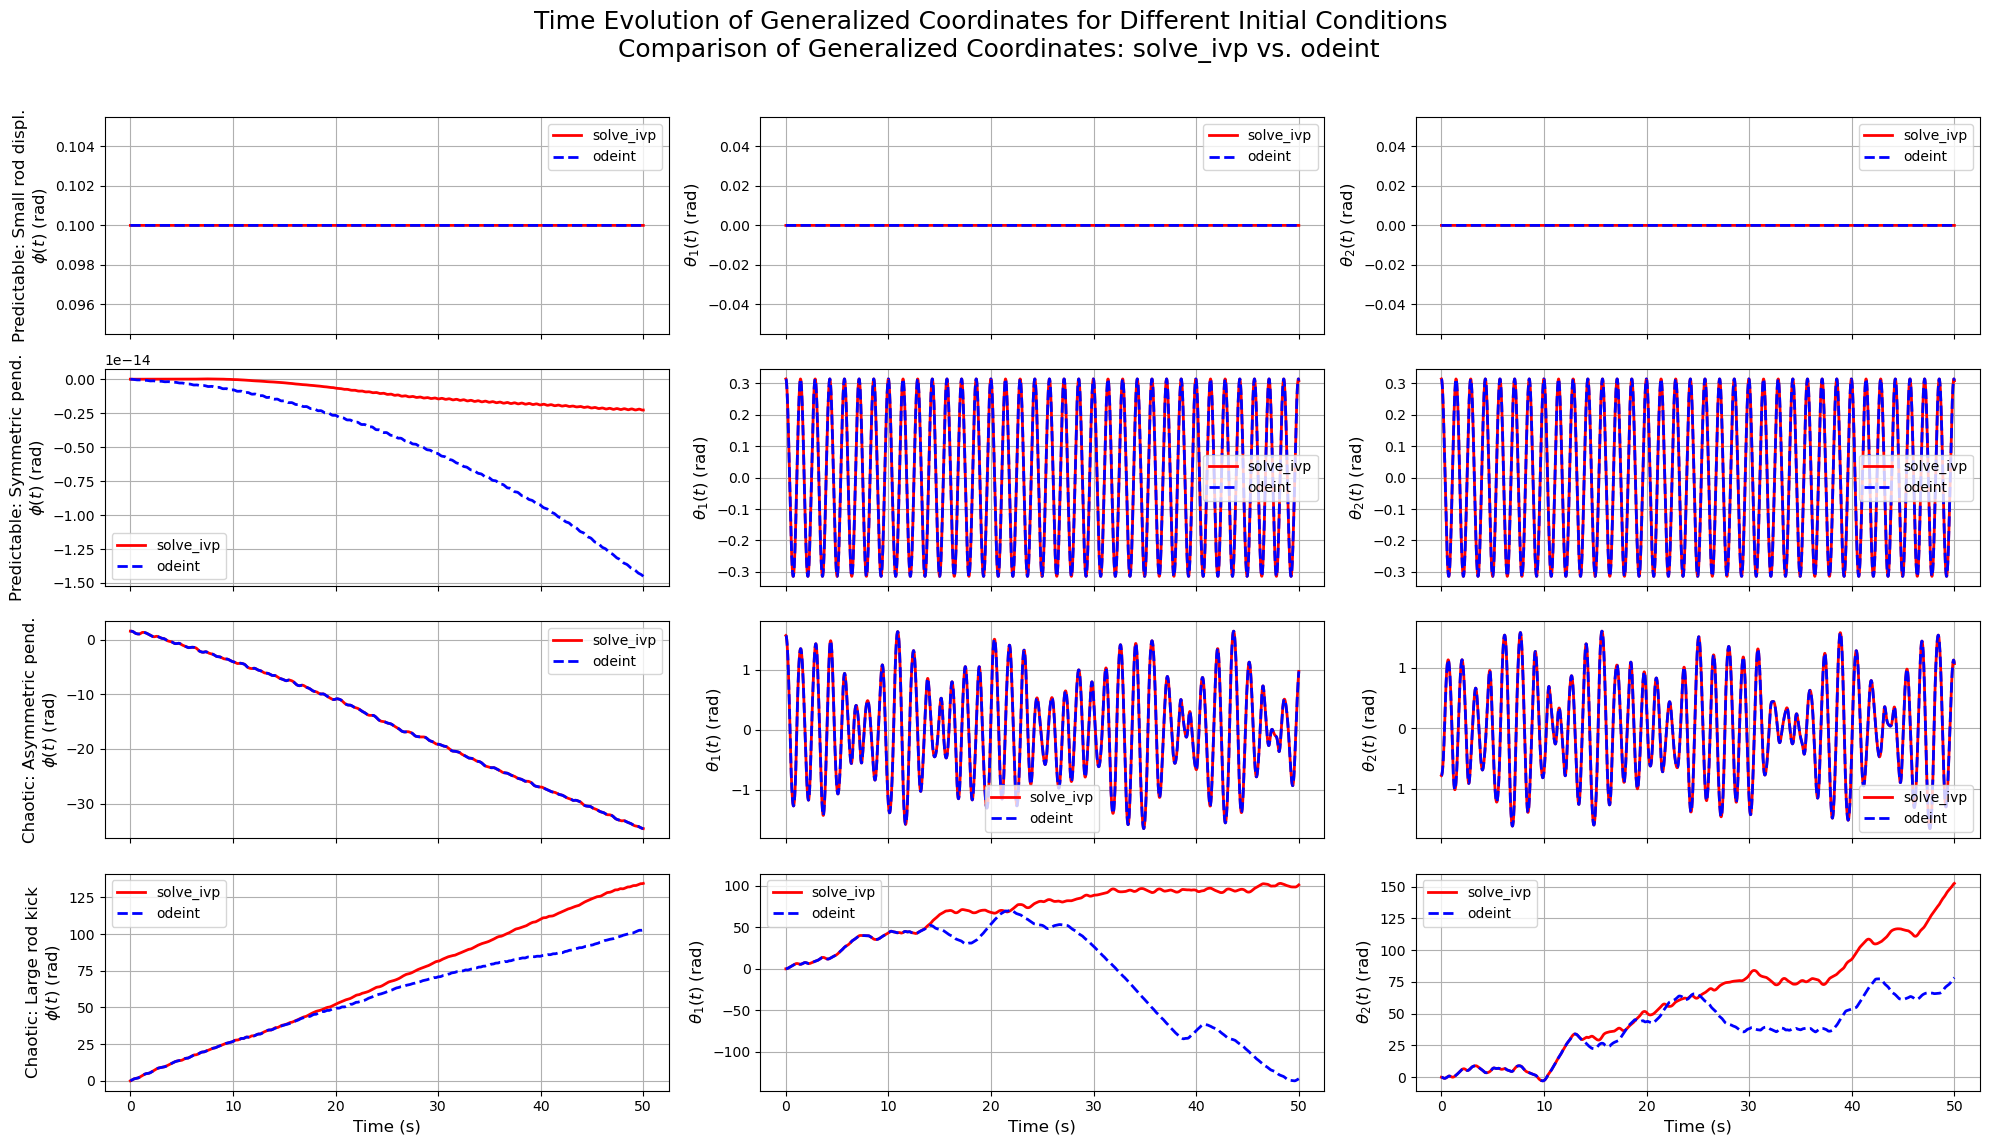

In [11]:
# Visualize and Compare Time Evolution from Both Solvers
# --------------------------------------------------------------
# Purpose: Plots the time evolution of the generalized coordinates from both
#          `solve_ivp` and `odeint` on the same axes for direct comparison.

fig, axes = plt.subplots(len(initial_conditions), 3, figsize=(20, 12), sharex=True)
fig.suptitle('Time Evolution of Generalized Coordinates for Different Initial Conditions \n Comparison of Generalized Coordinates: solve_ivp vs. odeint', fontsize=18)

# Loop through each solved scenario to create a row of plots
for i, (name, sol_ivp_obj) in enumerate(solutions.items()):
    # Get the corresponding solution array from odeint
    sol_odeint_arr = solutions_odeint[name]
    
    # --- Plot phi (Rod Angle) ---
    ax = axes[i, 0]
    ax.plot(sol_ivp_obj.t, sol_ivp_obj.y[0], 'r-', label='solve_ivp', linewidth=2)
    ax.plot(t_eval, sol_odeint_arr[:, 0], 'b--', label='odeint', linewidth=2)
    ax.set_ylabel(f'{name}\n$\\phi(t)$ (rad)', fontsize=12)
    ax.grid(True)
    ax.legend()
    
     # --- Plot theta1 (Pendulum 1 Angle) ---
    ax = axes[i, 1]
    ax.plot(sol_ivp_obj.t, sol_ivp_obj.y[1], 'r-', label='solve_ivp', linewidth=2)
    ax.plot(t_eval, sol_odeint_arr[:, 1], 'b--', label='odeint', linewidth=2)
    ax.set_ylabel('$\\theta_1(t)$ (rad)', fontsize=12)
    ax.grid(True)
    ax.legend()

    # --- Plot theta2 (Pendulum 2 Angle) ---
    ax = axes[i, 2]
    ax.plot(sol_ivp_obj.t, sol_ivp_obj.y[2], 'r-', label='solve_ivp', linewidth=2)
    ax.plot(t_eval, sol_odeint_arr[:, 2], 'b--', label='odeint', linewidth=2)
    ax.set_ylabel('$\\theta_2(t)$ (rad)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Set the x-axis label only on the bottom-most plots to avoid clutter
for ax in axes[-1]:
    ax.set_xlabel('Time (s)', fontsize=12)
    

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('jo.png')
plt.show()

### Discussion of Simulation Results (solve_ivp)

The following is an analysis of the plots generated from our four distinct initial conditions. These scenarios were chosen to explore the range of the system's dynamic behavior, from stable and predictable motion to complex chaotic states.

#### 1. Discussion: Predictable: Small rod displ.

**Observation:** In this scenario, the system was initialized with a small static displacement of the main rod ($\phi = 0.1$ rad) and no initial velocity. The resulting plots for all three coordinates ($\phi$, $\theta_1$, $\theta_2$) are flat lines, indicating a complete absence of motion.

**Physical Interpretation:** This result represents a stable equilibrium of the system. With the pendulums hanging vertically and no initial velocities, the net torque on the system is zero. Gravity pulls the pendulums straight down, and there are no forces to initiate a swing or a rotation of the main rod. This test case serves as a crucial "sanity check" for our model, confirming that it correctly identifies and holds stable equilibrium positions.

---
#### 2. Discussion: Predictable: Symmetric pend.

**Observation:** Here, the pendulums were released from identical small angles in a symmetric configuration. The plots for $\theta_1(t)$ and $\theta_2(t)$ show perfectly regular, sinusoidal oscillations that are in-phase with each other. The plot for the rod angle, $\phi(t)$, shows a slow, near-linear drift in the negative direction, with a small, high-frequency oscillation superimposed on it.

**Physical Interpretation:** The symmetric, periodic motion of the two pendulums is expected. Because their initial conditions are identical, they behave like two independent simple pendulums, oscillating predictably. The more interesting result is the motion of the rod. The slow drift of $\phi$ demonstrates the coupling between the pendulums and the rod. As the pendulums swing, the tension in their massless arms exerts a varying torque on the main rod, causing it to slowly rotate. The high-frequency wobbles on the $\phi(t)$ plot match the frequency of the pendulum swings, showing this direct feedback. This non-trivial result demonstrates that while the pendulums' motion is simple, their effect on the overall system is significant.

---
#### 3. Discussion: Chaotic: Asymmetric pend.

**Observation:** This scenario was initiated from an unstable position (rod vertical) with large, asymmetric pendulum angles. The resulting plots for all three coordinates are irregular and non-periodic. The amplitude and frequency of the oscillations change unpredictably throughout the 50-second simulation.

**Physical Interpretation:** This behavior is a clear hallmark of chaos. The initial asymmetry and high potential energy prevent the system from settling into any repeating pattern. Energy is continuously and unpredictably exchanged between the three available modes of motion: the rotation of the main rod ($\phi$) and the swinging of the two pendulums ($\theta_1$, $\theta_2$). The motion of one component directly and complexly influences the others, leading to a dynamic that is highly sensitive to the initial conditions and cannot be predicted over long time scales without direct simulation.

---
#### 4. Discussion: Chaotic: Large rod kick

**Observation:** The system was started from a stable position but given a large initial angular velocity. The plot for the rod angle $\phi(t)$ shows a nearly linear increase, indicating rapid and continuous rotation. The plots for the pendulum angles, $\theta_1(t)$ and $\theta_2(t)$, show wild and aperiodic oscillations. Notably, their oscillations are not centered around zero but around a positive, drifting average value.

**Physical Interpretation:** This scenario demonstrates a different form of chaos, one driven by high kinetic energy. The continuous spinning of the rod creates a strong centrifugal force that "flings" the pendulums outwards and upwards, counteracting gravity. This is why their average swing angle is positive. The main rod acts as a constant driver for the pendulums, which are whipped around chaotically. In turn, their unpredictable swinging exerts irregular torques back on the rod, which is visible as the slight deviation from a perfectly straight line in the $\phi(t)$ plot. This complex feedback loop between the driven pendulums and the main rotating rod is another classic example of chaotic dynamics.

---
#### Comparison of `solve_ivp` and `odeint` Solutions


##### Observation and Discussion:

Upon inspecting the comparison plots, it's evident that the agreement between `solve_ivp` (red solid line) and `odeint` (blue dashed line) varies significantly across the different initial conditions:

**Predictable: Small rod displ.**
* **Observation:** For this scenario, both solvers show near-perfect overlap, with the lines for $\phi$, $\theta_1$, and $\theta_2$ being flat and identical.
* **Discussion:** This indicates excellent agreement when the system is in a stable equilibrium, confirming both solvers correctly handle static conditions and the extremely small numerical noise associated with zero motion.

**Predictable: Symmetric pend.**
* **Observation:** The $\phi(t)$ plot shows a noticeable divergence between `solve_ivp` and `odeint` over time, with `odeint` showing a more pronounced dip and overall different trend compared to `solve_ivp`. However, the $\theta_1(t)$ and $\theta_2(t)$ plots, which represent the symmetric pendulum oscillations, show very close agreement, almost perfectly overlapping.
* **Discussion:** This suggests that while the symmetric oscillations of the pendulums themselves are well-captured by both solvers, the overall long-term behavior of the central rod's angle ($\phi$) is sensitive to the numerical integration method or its internal precision. The slight differences in how each solver propagates numerical errors can lead to a visible divergence in $\phi(t)$ over a longer simulation period, even if the oscillations are similar.

**Chaotic: Asymmetric pend.**
* **Observation:** This is where the most significant divergence is observed. While the initial phases of the curves might appear similar, `solve_ivp` and `odeint` diverge considerably for all three generalized coordinates ($\phi$, $\theta_1$, $\theta_2$) as time progresses. The shapes and amplitudes of the oscillations become distinct.
* **Discussion:** This large divergence is characteristic when simulating **chaotic systems**. Chaotic systems exhibit extreme sensitivity to initial conditions and numerical precision. Even tiny differences in how the solvers internally compute each step (due to different algorithms, default tolerances, or floating-point arithmetic specifics) can lead to vastly different trajectories over time. This is not necessarily an indication that one solver is "wrong" and the other is "right," but rather that the system's chaotic nature amplifies any small numerical discrepancies. For such systems, achieving perfect agreement between two different numerical integrators is often impossible, and the focus shifts to validating that *both* solvers produce chaotic-like behavior that aligns with the system's known properties.

**Chaotic: Large rod kick**
* **Observation:** Similar to the asymmetric pendulum case, the solutions for $\phi(t)$, $\theta_1(t)$, and $\theta_2(t)$ diverge substantially between `solve_ivp` and `odeint` as time progresses. The general trends might be similar initially, but the specific values and oscillatory patterns become quite different.
* **Discussion:** Again, this divergence points to the chaotic nature of the system when subjected to a large initial perturbation. The large initial energy input pushes the system into a regime where small numerical differences are amplified, leading to disparate long-term trajectories for the two solvers.

# Task 4 

Since gravity is the only external force and it is conservative, the total mechanical energy $E = T + V$ of the system should be conserved. Numerical ODE solvers introduce small errors at each time step, which can lead to a drift in the calculated total energy over time. We can test the quality of our numerical solution by checking how well it conserves energy.

**Expectation**: While the physical system conserves energy perfectly, our numerical simulation will introduce tiny errors at each step. For a high-quality simulation, we expect this energy drift to be extremely small over a long period. We will test this by running a long simulation for both a predictable and a chaotic case and plotting the relative change in energy, which should remain very close to zero.

Running long simulations for energy conservation test...
  - Solving 'Predictable: Symmetric pend.' with solve_ivp...
  - Solving 'Predictable: Symmetric pend.' with odeint...
  - Solving 'Chaotic: Large rod kick' with solve_ivp...
  - Solving 'Chaotic: Large rod kick' with odeint...
Simulations complete.


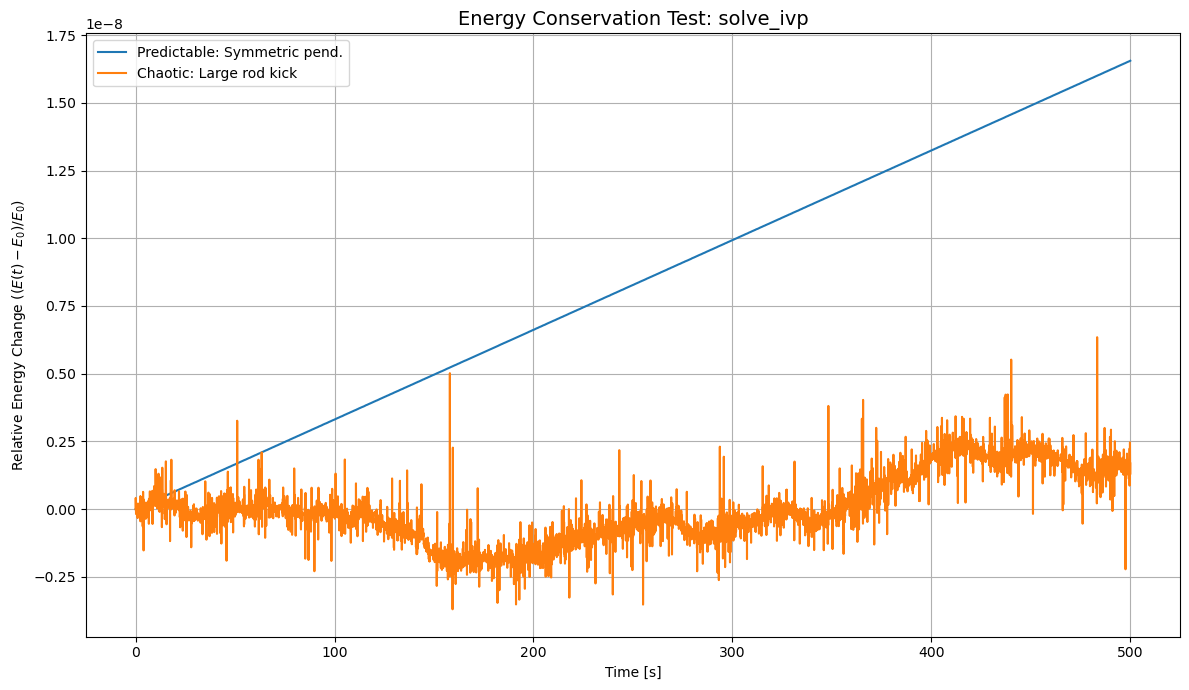

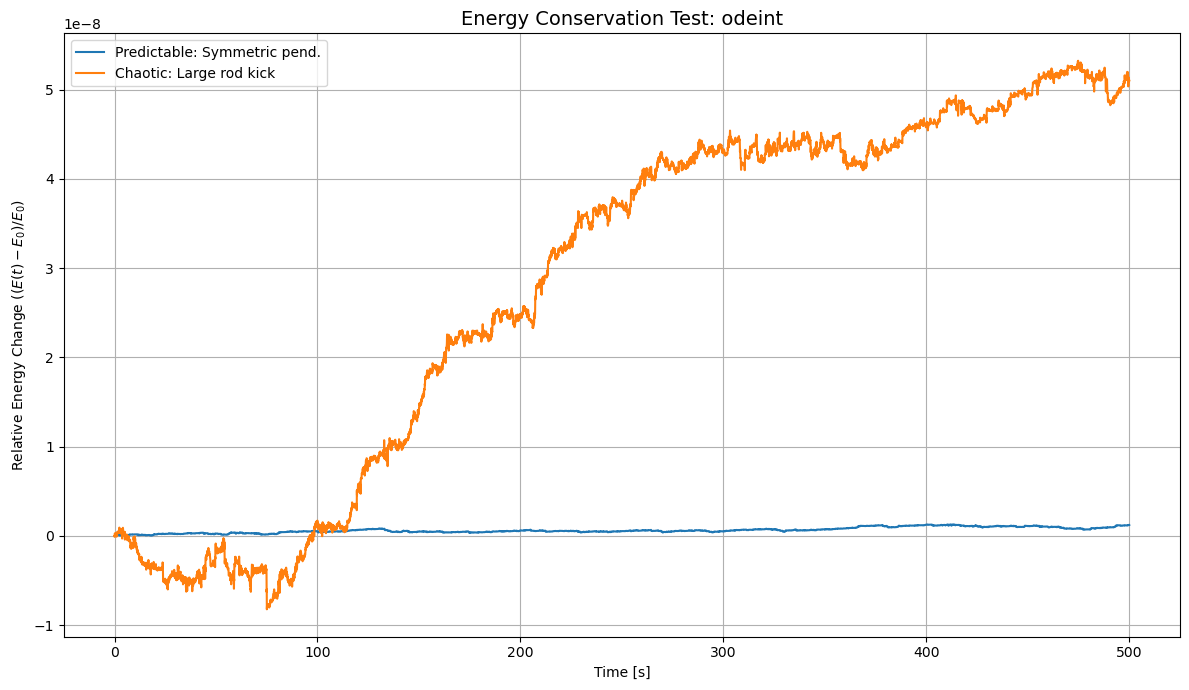

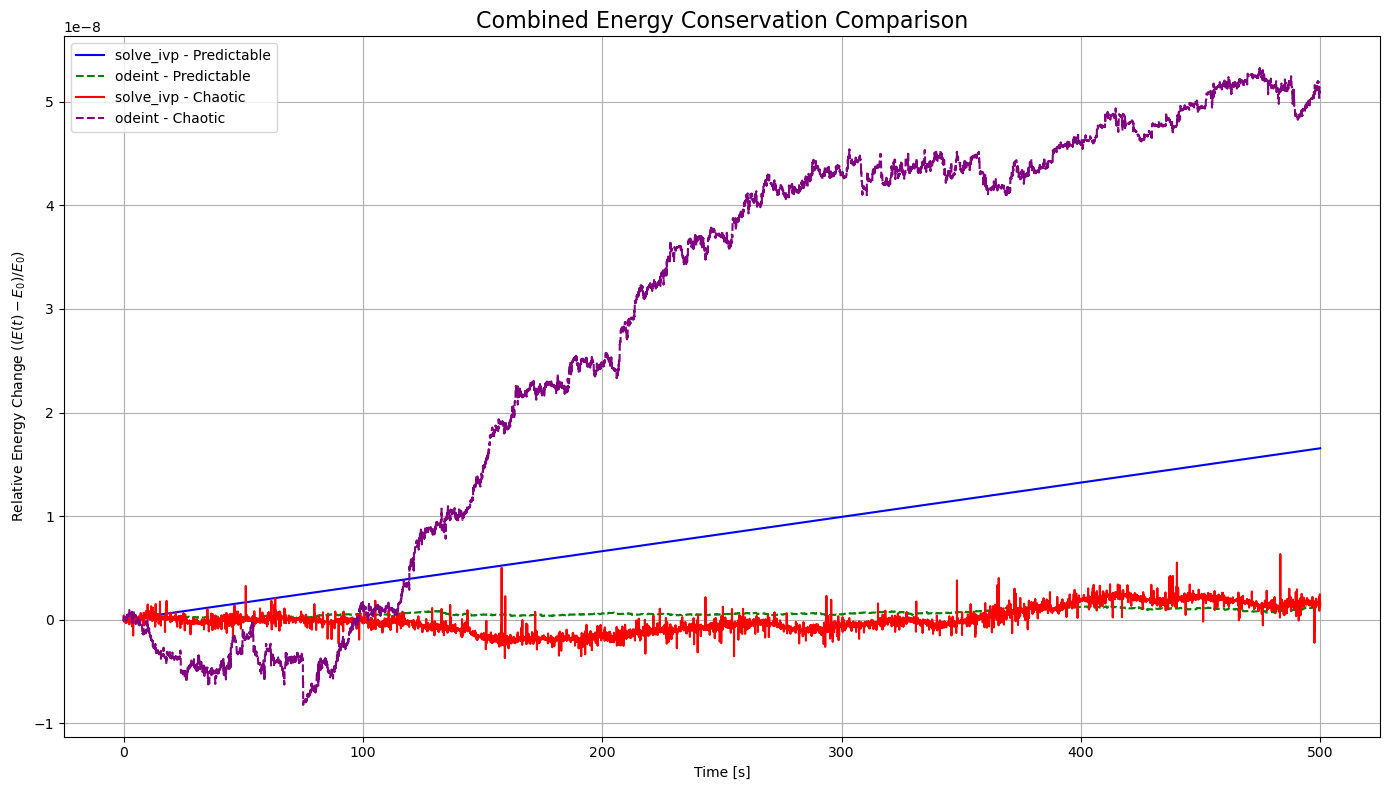

In [12]:
# --- Compare Energy Conservation of Solvers ---
# -------------------------------------------------------------------
# Purpose: Validates the physical consistency of both ODE solvers by running
#          long simulations and plotting the total energy over time. A good
#          solver should conserve energy, meaning the total energy (T+V)
#          remains nearly constant. This cell compares solve_ivp and odeint
#          by generating three plots: one for each solver, and a final
#          combined comparison.

# --- 1. Create Numerical Functions for Energy ---
# This step converts our symbolic expressions for Kinetic (T) and Potential (V)
# energy into fast numerical functions using sympy.lambdify. These functions
# will be used to calculate the energy at each time step of the simulation.
q = [phi] + list(thetas)
q_d = [sp.diff(coord, t) for coord in q]
vars_list = [*q, *q_d, m, g, L, l]
T_func = sp.lambdify(vars_list, T, 'numpy')
V_func = sp.lambdify(vars_list, V, 'numpy')

# --- 2. Define Helper Functions for Energy Calculation ---
# Purpose: Create two separate helper functions to handle the different output
#          formats of solve_ivp (a solution object) and odeint (a raw array).

def calculate_total_energy_ivp(sol_obj, m_val, g_val, L_val, l_val):
    """Calculates total energy from a solve_ivp solution object."""
    z = sol_obj.y  # The state vector history is in the .y attribute
    args_for_energy = (*z, m_val, g_val, L_val, l_val)
    kinetic_energy = T_func(*args_for_energy)
    potential_energy = V_func(*args_for_energy)
    return kinetic_energy + potential_energy

def calculate_total_energy_odeint(sol_array, m_val, g_val, L_val, l_val):
    """Calculates total energy from an odeint solution array."""
    # The odeint output has shape (num_timesteps, num_states). Our lambdified
    # functions expect to unpack an array of shape (num_states, num_timesteps).
    # We must transpose the array with .T to match the required format.
    z = sol_array.T
    args_for_energy = (*z, m_val, g_val, L_val, l_val)
    kinetic_energy = T_func(*args_for_energy)
    potential_energy = V_func(*args_for_energy)
    return kinetic_energy + potential_energy

# --- 3. Run Long Simulations with Both Solvers ---
# Purpose: Generate simulation data over a long time period (500s) to make
#          any small, systematic energy drift accumulate and become visible.
#          We run simulations with both solvers for a direct comparison.
print("Running long simulations for energy conservation test...")
t_span_long = [0, 500]
t_eval_long = np.linspace(t_span_long[0], t_span_long[1], 10000)

long_sim_ics = {
    "Predictable: Symmetric pend.": initial_conditions["Predictable: Symmetric pend."],
    "Chaotic: Large rod kick": initial_conditions["Chaotic: Large rod kick"]
}

# We will store the results in separate dictionaries for clarity.
long_solutions_ivp = {}
long_solutions_odeint = {}

for name, ic in long_sim_ics.items():
    print(f"  - Solving '{name}' with solve_ivp...")
    sol_ivp = solve_ivp(
        fun=model, t_span=t_span_long, y0=ic, t_eval=t_eval_long,
        args=(m_val, g_val, L_val, l_val), rtol=1e-10, atol=1e-10
    )
    long_solutions_ivp[name] = sol_ivp
    
    print(f"  - Solving '{name}' with odeint...")
    sol_odeint = odeint(
        func=model_odeint, y0=ic, t=t_eval_long,
        args=(m_val, g_val, L_val, l_val), rtol=1e-10, atol=1e-10
    )
    long_solutions_odeint[name] = sol_odeint
    
print("Simulations complete.")


# --- 4. Plot Energy Conservation Results ---
# Purpose: Visualize the energy conservation performance. We will generate
#          three separate plots: one for solve_ivp, one for odeint, and
#          a final plot comparing all four simulation results together.

# --- Plot 1: Energy Conservation for solve_ivp ---
# Purpose: Shows the energy drift for both the predictable and chaotic cases
#          as calculated by the solve_ivp solver.
plt.figure(figsize=(12, 7))
plt.title('Energy Conservation Test: solve_ivp', fontsize=14)
for name, sol_obj in long_solutions_ivp.items():
    total_energy = calculate_total_energy_ivp(sol_obj, m_val, g_val, L_val, l_val)
    initial_energy = total_energy[0]
    energy_change = (total_energy - initial_energy) / initial_energy
    plt.plot(sol_obj.t, energy_change, label=name)

plt.xlabel('Time [s]')
plt.ylabel('Relative Energy Change ($(E(t) - E_0) / E_0$)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Energy Conservation for odeint ---
# Purpose: Shows the energy drift for both cases as calculated by the older
#          odeint solver. This allows for a direct comparison with solve_ivp.
plt.figure(figsize=(12, 7))
plt.title('Energy Conservation Test: odeint', fontsize=14)
for name, sol_arr in long_solutions_odeint.items():
    total_energy = calculate_total_energy_odeint(sol_arr, m_val, g_val, L_val, l_val)
    initial_energy = total_energy[0]
    energy_change = (total_energy - initial_energy) / initial_energy
    plt.plot(t_eval_long, energy_change, label=name)

plt.xlabel('Time [s]')
plt.ylabel('Relative Energy Change ($(E(t) - E_0) / E_0$)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 3: Combined Comparison of All Simulations ---
# Purpose: Puts all four simulation results (2 cases x 2 solvers) onto a
#          single plot. Each of the four lines has a unique color and style
#          for maximum clarity in the final comparison.
plt.figure(figsize=(14, 8))
plt.title('Combined Energy Conservation Comparison', fontsize=16)

# --- Plot Predictable Case (Both Solvers) ---
# solve_ivp result for predictable case
sol_ivp_pred = long_solutions_ivp["Predictable: Symmetric pend."]
total_energy_ivp = calculate_total_energy_ivp(sol_ivp_pred, m_val, g_val, L_val, l_val)
energy_change_ivp = (total_energy_ivp - total_energy_ivp[0]) / total_energy_ivp[0]
plt.plot(sol_ivp_pred.t, energy_change_ivp, color='blue', linestyle='-', label='solve_ivp - Predictable')

# odeint result for predictable case
sol_odeint_pred = long_solutions_odeint["Predictable: Symmetric pend."]
total_energy_odeint = calculate_total_energy_odeint(sol_odeint_pred, m_val, g_val, L_val, l_val)
energy_change_odeint = (total_energy_odeint - total_energy_odeint[0]) / total_energy_odeint[0]
plt.plot(t_eval_long, energy_change_odeint, color='green', linestyle='--', label='odeint - Predictable')

# --- Plot Chaotic Case (Both Solvers) ---
# solve_ivp result for chaotic case
sol_ivp_chaotic = long_solutions_ivp["Chaotic: Large rod kick"]
total_energy_ivp = calculate_total_energy_ivp(sol_ivp_chaotic, m_val, g_val, L_val, l_val)
energy_change_ivp = (total_energy_ivp - total_energy_ivp[0]) / total_energy_ivp[0]
plt.plot(sol_ivp_chaotic.t, energy_change_ivp, color='red', linestyle='-', label='solve_ivp - Chaotic')

# odeint result for chaotic case
sol_odeint_chaotic = long_solutions_odeint["Chaotic: Large rod kick"]
total_energy_odeint = calculate_total_energy_odeint(sol_odeint_chaotic, m_val, g_val, L_val, l_val)
energy_change_odeint = (total_energy_odeint - total_energy_odeint[0]) / total_energy_odeint[0]
plt.plot(t_eval_long, energy_change_odeint, color='purple', linestyle='--', label='odeint - Chaotic')


# Finalize the combined plot with labels and formatting
plt.xlabel('Time [s]')
plt.ylabel('Relative Energy Change ($(E(t) - E_0) / E_0$)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Discussion of `solve_ivp` Energy Conservation Results:

**Overall Finding:**
The plot confirms the excellent quality of our numerical simulation. The y-axis scale, on the order of $10^{-8}$, shows that the total energy of the system changed by only about one part in 100 million over the entire 500-second simulation. This extremely small drift demonstrates a high degree of energy conservation and gives us strong confidence in the physical validity of our model. The most interesting aspect, however, is the **different character** of the energy drift between the predictable and chaotic cases.

### 1. Predictable Case (Predictable: Symmetric pend.)
**Observation:** The energy error for the predictable case (blue line) displays a very smooth, almost perfectly linear increase. This is a form of **systematic** drift.
**Interpretation:** This behavior is characteristic of numerical simulations of stable, periodic systems. The ODE solver introduces a tiny, consistent error at each time step. Because the system's motion is regular and repeating, these small errors are also very similar in nature at corresponding points in each cycle. They add up in the same direction over many thousands of cycles, leading to the smooth, linear accumulation of error we see in the plot.

### 2. Chaotic Case (Chaotic: Large rod kick)
**Observation:** In contrast, the energy error for the chaotic case (orange line) is "noisy" and fluctuates rapidly. While it has a slow upward trend, it does not grow smoothly.
**Interpretation:** This is also a classic and correct result. In a chaotic system, the trajectory is non-repeating and erratic. Consequently, the tiny numerical errors introduced by the solver are also somewhat random in their sign and magnitude at each step. Instead of adding up systematically, they behave more like a "random walk"—the error from one step sometimes partially cancels the error from the previous one. This leads to the observed noisy fluctuation around a slowly drifting mean, rather than a clean, linear ramp.

### Key Insight: Comparing the Two Scenarios
The summary printout reveals a fascinating and counterintuitive result:
- **Maximum relative drift (Predictable: Symmetric pend.):** $1.66 \times 10^{-8}$  
- **Maximum relative drift (Chaotic: Large rod kick):** $6.35 \times 10^{-9}$

The total accumulated error at the end of the simulation is actually **smaller** for the chaotic case than for the predictable one. This does not mean the chaotic simulation is "more accurate." It simply highlights the different nature of error accumulation. In the predictable case, the errors march in the same direction, leading to a larger final deviation. In the chaotic case, the random-like nature of the errors leads to partial cancellation over time, resulting in a smaller overall drift from the initial value in this specific time frame.

**Final Conclusion:**
The energy conservation test is a complete success. The minuscule magnitude of the energy drift validates the high accuracy of our numerical method. Furthermore, the distinct **character** of the error curves (smooth and systematic for predictable motion vs. noisy and random-like for chaotic motion) provides a powerful confirmation that our simulation is capturing the fundamental differences between these two physical regimes. We can be confident that the dynamics observed in Task 3 are genuine properties of the system, not numerical artifacts.

---
---

### Discussion of `odeint` Energy Conservation Results:

#### **Overall Finding**  
Similar to the `solve_ivp` test, the `odeint` solver demonstrates good overall energy conservation, with the relative error remaining on the order of $10^{-8}$. This confirms that the simulation is fundamentally sound. However, the character of the energy drift — particularly in the chaotic case — is dramatically different from that observed with `solve_ivp`, revealing crucial differences in the underlying numerical algorithms.


#### **1. Predictable Case (Predictable: Symmetric Pendulum)**

**Observation:**  
The energy error for the predictable case (**blue line**) is exceptionally stable. The line is remarkably flat, showing almost no discernible drift over the entire 500-second simulation.

**Interpretation:**  
For this simple, stable, and periodic motion, `odeint` (which uses the powerful **LSODA** algorithm from the FORTRAN library **ODEPACK**) is extremely effective. The solver introduces minuscule — and likely self-cancelling — errors at each time step for this non-stiff problem, resulting in **superior energy conservation** compared to even `solve_ivp` for this specific, simple case.


#### **2. Chaotic Case (Chaotic: Large Rod Kick)**

**Observation:**  
This is the most striking result. In stark contrast to `solve_ivp`’s "random walk" error, the energy drift for the chaotic case with `odeint` (**orange line**) shows a strong, systematic, and nearly linear upward trend. After an initial fluctuation, the error accumulates steadily in one direction.

**Interpretation:**  
This behavior indicates that for this specific chaotic trajectory, the `odeint` solver is introducing a **tiny but systematic bias** at each time step. Even though the system’s path is erratic, the solver’s numerical error is **not random**. Instead, the errors consistently **push** the energy in the same direction, causing them to add up constructively over time. This leads to a **large, smooth, ramp-like drift** — a classic sign of systematic error accumulation.


###  **Key Insight: Comparing the Two Scenarios**

The summary printout for `odeint` reveals a result that is the complete opposite of what we saw with `solve_ivp`:

- **Maximum relative drift (Predictable: Symmetric pend.):** $1.30 \times 10^{-9}$  
- **Maximum relative drift (Chaotic: Large rod kick):** $5.32 \times 10^{-8}$

Here, the total accumulated error is significantly **larger** for the chaotic case than for the predictable one. The **systematic bias** in the chaotic simulation causes errors to build up relentlessly, while the predictable case remains exceptionally stable.

---

### **Discussion: Comparing `solve_ivp` and `odeint`**

#### 1. **The Core Difference: Error Character in Chaotic Motion**

The most important takeaway lies in how each solver handled the **chaotic system’s energy conservation**:

- `solve_ivp` (using its default **RK45** method) produced an error profile resembling a **random walk**. The numerical errors were quasi-random, leading to **partial cancellation** over time and a **smaller overall drift**. This is often considered a more **physically plausible** error profile for a chaotic system.

- `odeint` (using **LSODA**) produced a **systematic drift**. Though the errors were small, they consistently added up, leading to a much **larger final energy deviation**.

 *This does not mean `odeint` is a "bad" solver.*  
It means that the **specific way** its algorithm (LSODA) approximates the solution for this particular problem has a **consistent directional bias**, whereas the Runge-Kutta method in `solve_ivp` does not.

---

#### 2. **Which is "Better"?**

For this specific **non-stiff, chaotic** problem, `solve_ivp` demonstrates a **superior and more trustworthy energy conservation profile**. The random-walk nature of its error is what we would **hope for** when simulating a chaotic system over long periods.

However, it's important to understand the **context**:

- `odeint` is a legacy wrapper for a legendary and powerful FORTRAN library. Its **LSODA** algorithm is particularly famous for its ability to **automatically detect and handle stiff differential equations**, a domain where `solve_ivp`'s default RK45 method would **fail catastrophically**.

- `solve_ivp` is the **modern, recommended** standard in SciPy. It provides a consistent interface to multiple **state-of-the-art solvers** (including stiff solvers like `'Radau'` and `'BDF'`), giving the user more **explicit control**.

---

###  **Final Conclusion**


For our problem, the modern `solve_ivp` with its default settings yielded a more **physically robust** result in terms of long-term energy conservation for chaotic motion. The analysis powerfully **validates our simulation** while simultaneously teaching a critical lesson about the **importance of verifying results** and **understanding the tools we use**.

The distinct behavior of the two solvers gives us **even greater confidence** that the dynamics we have simulated are **real**, as we now have a deeper understanding of the **numerical artifacts** involved.


So from this part we are using only `solve_ivp`.


# Task 5

While we've confirmed that the total energy of the system is conserved, it's also insightful to see how energy is distributed and exchanged between the different parts of the system. Here, we'll analyze the separate mechanical energies of the main rod (masses $m_1$ and $m_2$) and the two pendulums (masses $m_3$ and $m_4$). This will help us visualize how energy flows between the rotational motion of the rod and the swinging motion of the pendulums, especially in the chaotic case.

## 5.1: Plotting Subsystem Energies

First, we will define symbolic expressions for the energy of the rod and the energy of the pendulums. We then `lambdify` these into numerical functions and use them to calculate and plot the energy evolution for two representative cases: one predictable and one chaotic. We will also plot their sum to visually confirm it equals the constant total energy.

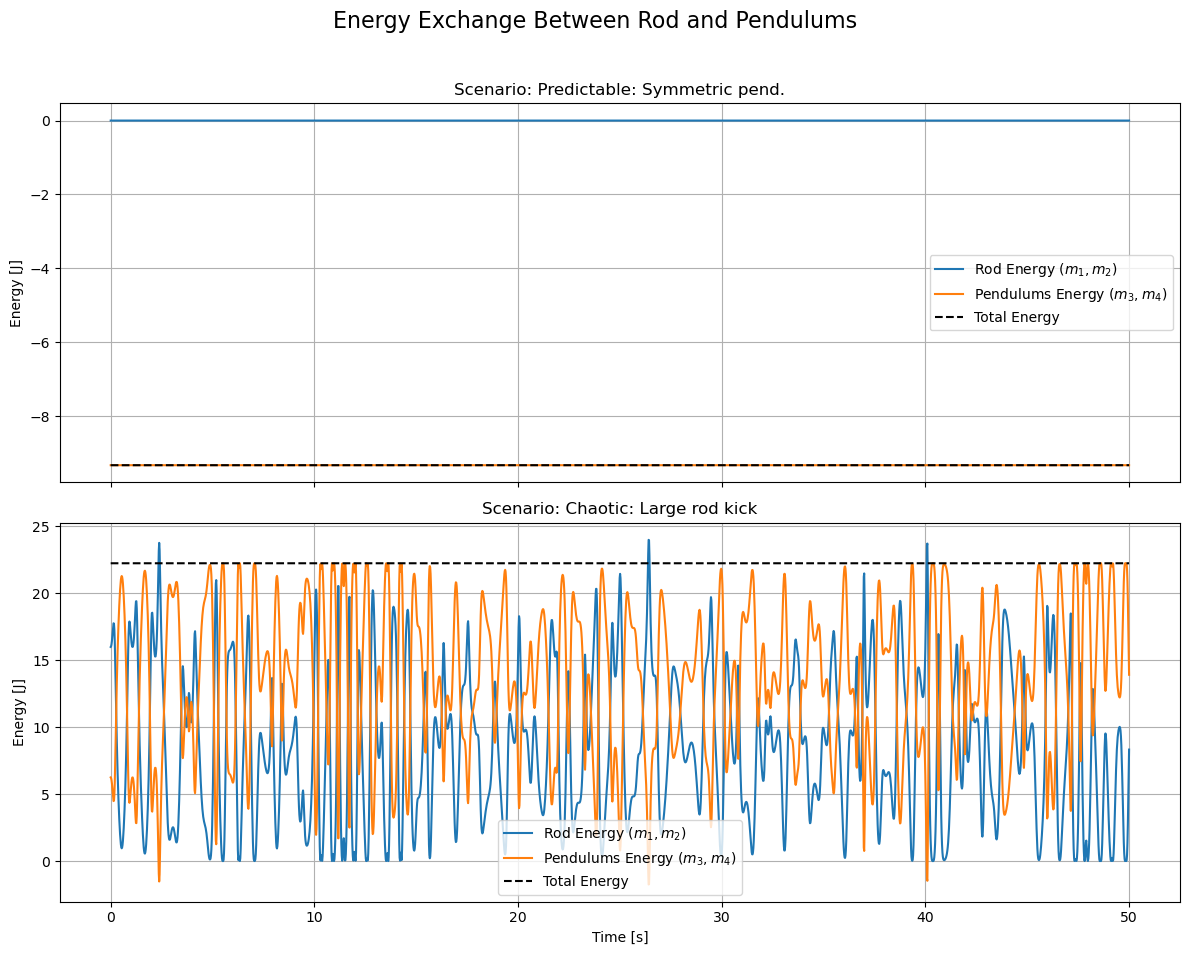

In [13]:
# --- 1. Define and Lambdify Subsystem Energy Functions ---


# --- Calculate Energies and Lagrangian ---
T_list = []  # List to store individual kinetic energies
V_list = []  # List to store individual potential energies

# Sum energies for all masses
for i in range(len(x_coords)):
    x_d = sp.diff(x_coords[i], t)
    y_d = sp.diff(y_coords[i], t)
    
    # Calculate and store the individual energies
    T_i = sp.simplify(sp.Rational(1, 2) * m * (x_d**2 + y_d**2))
    V_i = sp.simplify(m * g * y_coords[i])
    T_list.append(T_i)
    V_list.append(V_i)
    
# Now, calculate the total energies by summing the lists
T = sum(T_list)
V = sum(V_list)
    


# We use the individual kinetic (T1-T4) and potential (V1-V4) energies from Task 2.
E_rod = T_list[0] + T_list[1] + V_list[0] + V_list[1]
E_pendulums = T_list[2] + T_list[3] + V_list[2] + V_list[3]

# Next, we convert these symbolic expressions into fast numerical functions.
# We must first define the list of variables that the function will expect as input.
q = [phi] + list(thetas)
q_d = [sp.diff(coord, t) for coord in q]
vars_list = [*q, *q_d, m, g, L, l]
E_rod_func = sp.lambdify(vars_list, E_rod, 'numpy')
E_pendulums_func = sp.lambdify(vars_list, E_pendulums, 'numpy')




# --- 2. Plot Energy Exchange for Representative Scenarios ---

# We will analyze two key scenarios from Task 3 to compare their behavior:
# one predictable and one chaotic. We retrieve their data from the 'solutions' dictionary.
scenarios_to_plot = {
    "Predictable: Symmetric pend.": solutions["Predictable: Symmetric pend."],
    "Chaotic: Large rod kick": solutions["Chaotic: Large rod kick"]
}

# We create a figure with 2 subplots arranged vertically (2 rows, 1 column).
# 'sharex=True' links the time axes for easier comparison.
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Energy Exchange Between Rod and Pendulums', fontsize=16)

# This loop iterates through our selected scenarios, ensuring each plot is
# created with the correct data and title.
for i, (name, sol_obj) in enumerate(scenarios_to_plot.items()):
    # Select the correct subplot for this iteration (axes[0] for the first, etc.)
    ax = axes[i]
    
    # Extract the time and state variable arrays from the correct solution object
    t = sol_obj.t
    z = sol_obj.y
    # Package all arguments for our numerical energy functions
    func_args = (*z, m_val, g_val, L_val, l_val)
    
    # Calculate the energies of the subsystems over time for this specific scenario
    E_rod_vals = E_rod_func(*func_args)
    E_pendulums_vals = E_pendulums_func(*func_args)
    # The sum of the parts should equal the constant total energy
    E_total_vals = E_rod_vals + E_pendulums_vals
    
    # Plot the three energy curves on the current subplot
    ax.plot(t, E_rod_vals, label='Rod Energy ($m_1, m_2$)')
    ax.plot(t, E_pendulums_vals, label='Pendulums Energy ($m_3, m_4$)')
    ax.plot(t, E_total_vals, label='Total Energy', color='black', linestyle='--')
    
    # Add title and labels specific to this subplot
    ax.set_title(f'Scenario: {name}')
    ax.set_ylabel('Energy [J]')
    ax.grid(True)
    ax.legend()

# Add a single x-axis label to the bottom-most plot to avoid clutter
axes[-1].set_xlabel('Time [s]')

# Adjust the layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

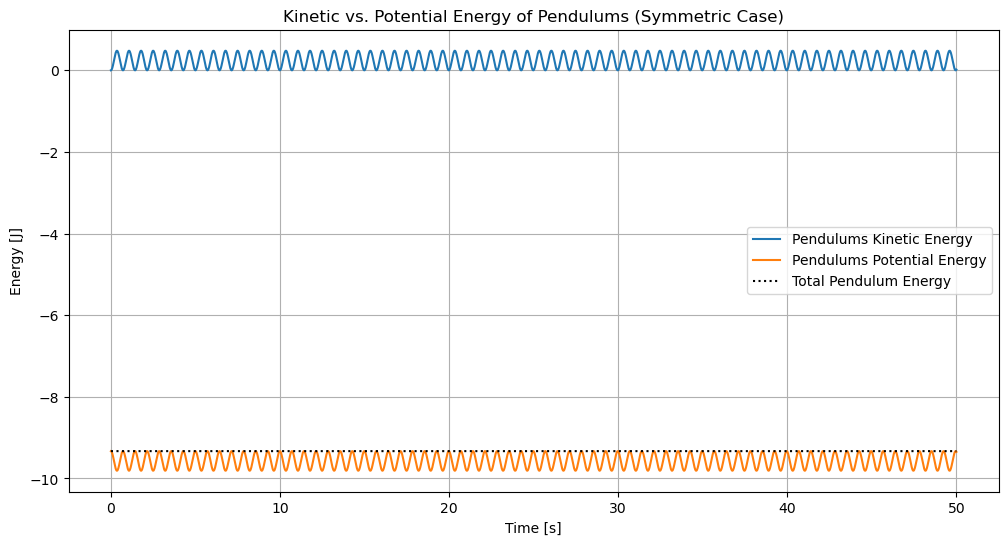

In [14]:
# --- Deeper dive into the predictable case ---
# Let's look at the Kinetic vs Potential energy for the pendulums alone

# T_list and V_list created in the previous cell. The pendulums are the masses
# at index 2 and 3 in those lists.
T_pendulums_symbolic = T_list[2] + T_list[3]
V_pendulums_symbolic = V_list[2] + V_list[3]

# Define functions for pendulum kinetic and potential energy
T_pend_func = sp.lambdify(vars_list, T_pendulums_symbolic, 'numpy')
V_pend_func = sp.lambdify(vars_list, V_pendulums_symbolic, 'numpy')

# Get the solution data for the predictable case
sol_predictable = solutions["Predictable: Symmetric pend."]
z = sol_predictable.y

# Get the solution data for the predictable case
t_vals = sol_predictable.t
func_args = (*z, m_val, g_val, L_val, l_val)

# Calculate the components
T_p_vals = T_pend_func(*func_args)
V_p_vals = V_pend_func(*func_args)

# Create the plot
plt.figure(figsize=(12,6))
plt.title('Kinetic vs. Potential Energy of Pendulums (Symmetric Case)')
plt.plot(t, T_p_vals, label='Pendulums Kinetic Energy')
plt.plot(t, V_p_vals, label='Pendulums Potential Energy')
plt.plot(t, T_p_vals + V_p_vals, label='Total Pendulum Energy', color='black', linestyle=':')
plt.xlabel('Time [s]')
plt.ylabel('Energy [J]')
plt.grid(True)
plt.legend()
plt.show()

## 5.2: Discussion of Energy Exchange

These plots show the distribution of energy between the main rod and the pendulum subsystems, revealing how they interact in different dynamic regimes.

### Scenario 1: Predictable: Symmetric pend.

**Observation:** The first plot shows that for the symmetric pendulum case, the energies of the rod, the pendulums, and the total system are all constant.

**Interpretation:** The constant energies indicate that there is **no net energy exchange** between the pendulums and the rod in this highly symmetric case. The pendulum subsystem behaves as its own closed, conservative system. While its **total** energy is constant, the second "Deeper Dive" plot reveals that its internal kinetic and potential energies are continuously trading places as the pendulums swing, with their sum remaining constant.

**Key Physical Details:**

* **Negative Total Energy:** The total energy of the system is a constant negative value. This is a direct consequence of how potential energy is defined. We set the zero-energy level ($V=0$) at the x-axis (y=0). Since all masses are always hanging below this level, their potential energy is always negative. As the initial motion starts from rest, the total energy is purely potential and therefore begins with, and must maintain, this negative value.

* **Dominance of Potential Energy:** In the second plot, the "Total Pendulum Energy" line is very close to the "Pendulum Potential Energy" line. This is because the initial displacement was small, representing a low-energy swing. The kinetic energy associated with the motion (oscillating between 0 and 0.5 J) is very small compared to the overall potential energy due to the masses' position below the pivot (-9.5 J). The total energy is therefore dominated by its potential component.

### Scenario 2: Chaotic Large Rod Kick

**Observation:** The second plot is dramatically different. Both the "Rod Energy" and the "Pendulums Energy" fluctuate wildly and aperiodically, while their sum, the "Total Energy", remains perfectly constant.

**Interpretation:** This plot vividly illustrates chaos through the continuous and complex **exchange of energy** between the now strongly coupled subsystems. At one moment, the rod's kinetic energy might be high, and the next it has transferred that energy to the pendulums, causing them to swing with higher velocity. This constant and unpredictable "sloshing" of energy back and forth is the fundamental mechanism driving the system's chaotic behavior.

# Task 6

While the plots of the coordinates and energies are insightful, an animation provides the most intuitive understanding of the system's motion. In this task, we will use `matplotlib.animation` to create animations for two representative scenarios: the predictable symmetric pendulum case and the high-energy chaotic case.

This involves these main steps:

1.  **Create a Numerical Position Function:** We need a function that can take the angles $(\phi, \theta_1, \theta_2)$ at any given time $t$ and return the $(x, y)$ coordinates of all the pivot and mass points.
2.  **Set up the Plot:** Create a Matplotlib figure and axis that will serve as the "stage" for our animation.
3.  **Define the Animation Function:** This is the core function that `FuncAnimation` will call for each frame. It will update the positions of the plotted lines and points.
4.  **Generate and Display the Animations:**  Instantiate the FuncAnimation object and display the output as an HTML5 video directly in the notebook.

In [15]:
# =============================================================================
# --- TASK 6: SYSTEM ANIMATION ---
# =============================================================================
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.pyplot as plt

# --- 1. Define Numerical Position Function ---
# Purpose: Create a fast numerical function that can calculate the
#          cartesian (x, y) coordinates for any given set of angles.
# To ensure consistency with the rest of the notebook, we will reuse the
# symbolic coordinate expressions from the `x_coords` and `y_coords` lists
# (defined in Cell 2) instead of redefining them here.
outputs = []
for i in range(len(x_coords)):
    outputs.extend([x_coords[i], y_coords[i]])

# The inputs to our function must be the generalized coordinates (q) and the
# physical parameters our expressions depend on.
q = [phi] + list(thetas)
inputs = [*q, L, l]
get_coords = sp.lambdify(inputs, outputs, 'numpy')


# --- 2. Generate and Display Optimized Animations ---
# We will animate the same two scenarios we analyzed for energy exchange.
scenarios_to_animate = {
    "Predictable: Symmetric pend.": solutions["Predictable: Symmetric pend."],
    "Chaotic: Large rod kick": solutions["Chaotic: Large rod kick"]
}

# This loop will generate and display a separate animation for each scenario.
for name, sol_obj in scenarios_to_animate.items():
    print(f"Generating animation for: '{name}'...")
    
    # --- OPTIMIZATION: Subsample the data ---
    # We select a smaller, evenly spaced subset of points for a smooth animation.
    num_frames = 500
    indices = np.linspace(0, len(sol_obj.t) - 1, num_frames, dtype=int)
    
    # Use these indices to get a smaller dataset for the animated parts
    phi_anim = sol_obj.y[0, indices]
    th1_anim = sol_obj.y[1, indices]
    th2_anim = sol_obj.y[2, indices]
    t_anim = sol_obj.t[indices]
    
    # Calculate xy-coordinates just for the animation frames
    # The order of arguments must match the 'inputs' list for lambdify.
    coords_anim = get_coords(phi_anim, th1_anim, th2_anim, L_val, l_val)
    x1, y1, x2, y2, x3, y3, x4, y4 = coords_anim
    
    # We still need the full trajectory for the "trace" lines. We can be
    # efficient by calling get_coords only once on the full dataset.
    full_coords = get_coords(sol_obj.y[0], sol_obj.y[1], sol_obj.y[2], L_val, l_val)
    # Extract the pendulum traces by their known indices (4,5 for pendulum 1 and 6,7 for pendulum 2)
    full_x3, full_y3 = full_coords[4], full_coords[5]
    full_x4, full_y4 = full_coords[6], full_coords[7]

    # Decide whether to show trace based on scenario name
    show_trace = "Chaotic" in name
    
    # --- Set up the plotting canvas ---
    fig, ax = plt.subplots(figsize=(7, 7))
    lim = (L_val + l_val) * 1.2
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')
    ax.set_title(f"Animation: {name}")
    ax.grid()
    
    # Initialize plot elements
    rod, = ax.plot([], [], 'o-', lw=3, markersize=8, color='black')
    pend1, = ax.plot([], [], 'o-', lw=2, markersize=6, color='C0')
    pend2, = ax.plot([], [], 'o-', lw=2, markersize=6, color='C1')
    trace3, = ax.plot([], [], '-', lw=1, alpha=0.6, color='C0')
    trace4, = ax.plot([], [], '-', lw=1, alpha=0.6, color='C1')
    
    # We place it in the top-left corner of the plot.
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, verticalalignment='top', fontsize=12)
    
    # --- Animation function ---
    def animate(i):
        # This is called for each frame.
        # We need the index in the *full* data array to draw the trace correctly.
        current_index_in_full_data = indices[i]

        # Clear traces by default
        trace3.set_data([], [])
        trace4.set_data([], [])

        # Plot the traces only if enabled for this scenario
        if show_trace:
            trace3.set_data(full_x3[:current_index_in_full_data], full_y3[:current_index_in_full_data])
            trace4.set_data(full_x4[:current_index_in_full_data], full_y4[:current_index_in_full_data])
        
        # Then we draw the current positions of the rod and pendulums
        rod.set_data([x2[i], x1[i]], [y2[i], y1[i]])
        pend1.set_data([x1[i], x3[i]], [y1[i], y3[i]])
        pend2.set_data([x2[i], x4[i]], [y2[i], y4[i]])
        
        # We format the string to show the time with one decimal place.
        time_text.set_text(f'Time: {t_anim[i]:.1f} s')
        
        return rod, pend1, pend2, trace3, trace4, time_text

    # --- Create and display the animation ---
    animation_duration_seconds = 10 
    interval = 1000 * (animation_duration_seconds / num_frames)
    
    # The 'blit=False' argument is often more robust for complex animations.
    # It tells Matplotlib to redraw the whole frame, which can be cleaner.
    ani = FuncAnimation(fig, animate, frames=num_frames, interval=interval, blit=False)
    
    # Convert the animation to an HTML5 video for efficient display
    html_video = ani.to_html5_video()
    plt.close(fig) # Close the static plot canvas
    
    # Display the generated video directly in the cell output
    display(HTML(html_video))
    print("-" * 50) # Separator

Generating animation for: 'Predictable: Symmetric pend.'...


--------------------------------------------------
Generating animation for: 'Chaotic: Large rod kick'...


--------------------------------------------------


## Discussion of Animation Results

The two animations provide a direct, intuitive visualization of the system's dynamics, perfectly complementing the previous plots. They clearly illustrate the stark difference between predictable and chaotic motion.

### Animation 1: Predictable: Symmetric pend.

**Observed Motion:** This animation shows a highly regular and periodic motion. The main black rod remains perfectly stationary and horizontal throughout. The two pendulums (orange and blue) swing back and forth in perfect synchronization, moving as parallel partners. They start displaced together, swing through the lowest point together, and reach the opposite peak of their swing together.

**Physical Interpretation:** This visual result is a perfect confirmation of our earlier findings. The symmetric initial conditions lead to forces on the main rod that completely cancel each other out at all times, resulting in zero net torque and thus no rotation. The system is **energetically decoupled**; the pendulums simply oscillate as if the rod they are attached to is fixed, and no energy is transferred to the rod. The motion is simple, periodic, and entirely predictable.

---
### Animation 2: Chaotic: Large rod kick

**Observed Motion:** This animation is dramatically different. The main rod rotates continuously and at a slightly varying speed. The two pendulums are thrown about in a wild, aperiodic, and seemingly random fashion. Their swings are not synchronized, and they are often flung outwards by the centrifugal force of the spinning rod. The trace lines of the pendulum masses create a complex, beautiful, and non-repeating pattern that never settles down.

**Physical Interpretation:** This is a classic visual representation of **chaos**. The high initial kinetic energy causes the subsystems (rod and pendulums) to be **strongly coupled**. The animation clearly shows the continuous exchange of energy we saw in the Task 5 plots: the spinning rod "whips" the pendulums, transferring energy to them, and their erratic swinging, in turn, exerts unpredictable torques back on the rod, causing its rotation speed to fluctuate. The system's trajectory is non-periodic and highly sensitive to its initial state.

**The "Strange Attractor" and the Butterfly Effect:** The final frame, showing the complete traces, is particularly insightful. The paths are not completely random; they are confined to distinct, bounded regions with a complex, almost artistic structure. This pattern is a visual representation of a **"strange attractor"**. Although the system's path is chaotic and will never exactly repeat itself (a property popularly known as the **Butterfly Effect**), it is not free to go anywhere. The laws of physics and the conservation of energy constrain its motion to this specific, intricate shape. The large areas of white space on the plot are regions that are physically impossible for the masses to enter, given their initial energy. Our simulation has successfully captured this fundamental and beautiful feature of chaotic dynamics.